# Exploring the Fama-French Momentum data-set

Momentum and Value are the most persistent "anomalies" in equity investing. But what these mean to an academic is often completely different from how these are applied in practice.

Academics call these "anomalies" because the standard CAPM/efficient-market model doesn't describe why these effects exists. They show that these effects are persistent by creating a long-short portfolio. For example, a momentum portfolio would be long the universe of stocks with “high” momentum and short the universe with “low” momentum.

However, in the real world, almost all portfolios are long-only. Also, there are constraints in terms of the universe of stocks because of liquidity, size, etc. Market beta plays a smaller role in a long-short momentum portfolio compared to the long-only portfolio. So a real-world long-only momentum portfolio’s return profile will be completely different from that of a long-short academic portfolio.

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")

#initialize
famaFrench <- FamaFrench()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from

## Momentum Factor

The Fama-French momentum factor is the **average** return of two high prior return portfolios *minus* the **average** return of two low prior return portfolios. Each portfolio has a size (market-equity) element thrown into the mix.

Here's the complete description from their [website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor_daily.html):

```
We use six value-weight portfolios formed on size and prior (2-12) returns to construct Mom. The portfolios, which are formed daily, are the intersections of 2 portfolios formed on size (market equity, ME) and 3 portfolios formed on prior (2-12) return. The daily size breakpoint is the median NYSE market equity. The daily prior (2-12) return breakpoints are the 30th and 70th NYSE percentiles.

Mom is the average return on the two high prior return portfolios minus the average return on the two low prior return portfolios,

 	Mom = 1/2 (Small High + Big High) - 1/2(Small Low + Big Low).
```

Fama-French publish both daily and monthly returns of the Momentum Factor. We will look at each in turn.

### Daily Returns

In this data-set, the portfolio is rebalanced on a daily basis. Not very practical but it gives us an idea of how the factor behaves through time.

In [2]:
dailyMom <- famaFrench$MomentumDaily() %>%
    filter(KEY_ID == 'MOM') %>%
    select(TIME_STAMP, RET) %>%
    collect()
    
dailyMomXts <- xts(dailyMom$RET/100, dailyMom$TIME_STAMP)

print("Momentum Returns: ")
print(head(dailyMomXts))
print(tail(dailyMomXts))

[1] "Momentum Returns: "
              [,1]
1926-11-03  0.0057
1926-11-04 -0.0052
1926-11-05  0.0115
1926-11-06 -0.0004
1926-11-08 -0.0001
1926-11-09  0.0017
              [,1]
2019-06-21 -0.0013
2019-06-24  0.0071
2019-06-25 -0.0039
2019-06-26 -0.0199
2019-06-27 -0.0007
2019-06-28 -0.0054


In [3]:
plotRollingDailyReturns <- function(numYears){
    numDays <- 220 * numYears
    rollRet <- rollapply(dailyMomXts, numDays, Return.cumulative)
    rollRet <- 100*na.omit(rollRet)
    names(rollRet) <- c('RET')
    
    rollRetDf <- data.frame(rollRet)
    rollRetDf$T <- index(rollRet)

    firstDate <- first(index(rollRet))
    lastDate <- last(index(rollRet))
    xAxisTicks <- seq(from=firstDate, to=lastDate, length.out=10)

    ggplot(rollRetDf, aes(x=T, y=RET)) +
        theme_economist() +
        geom_line() +
        scale_x_date(breaks = xAxisTicks) +
        labs(x='', y='cumulative return (%)', color='', 
             title=sprintf("Momentum Factor %d-year Daily Rolling Returns", numYears), 
             subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
        annotate("text", x=lastDate, y=min(rollRetDf$RET, na.rm=T), label = "@StockViz", 
                 hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)
}

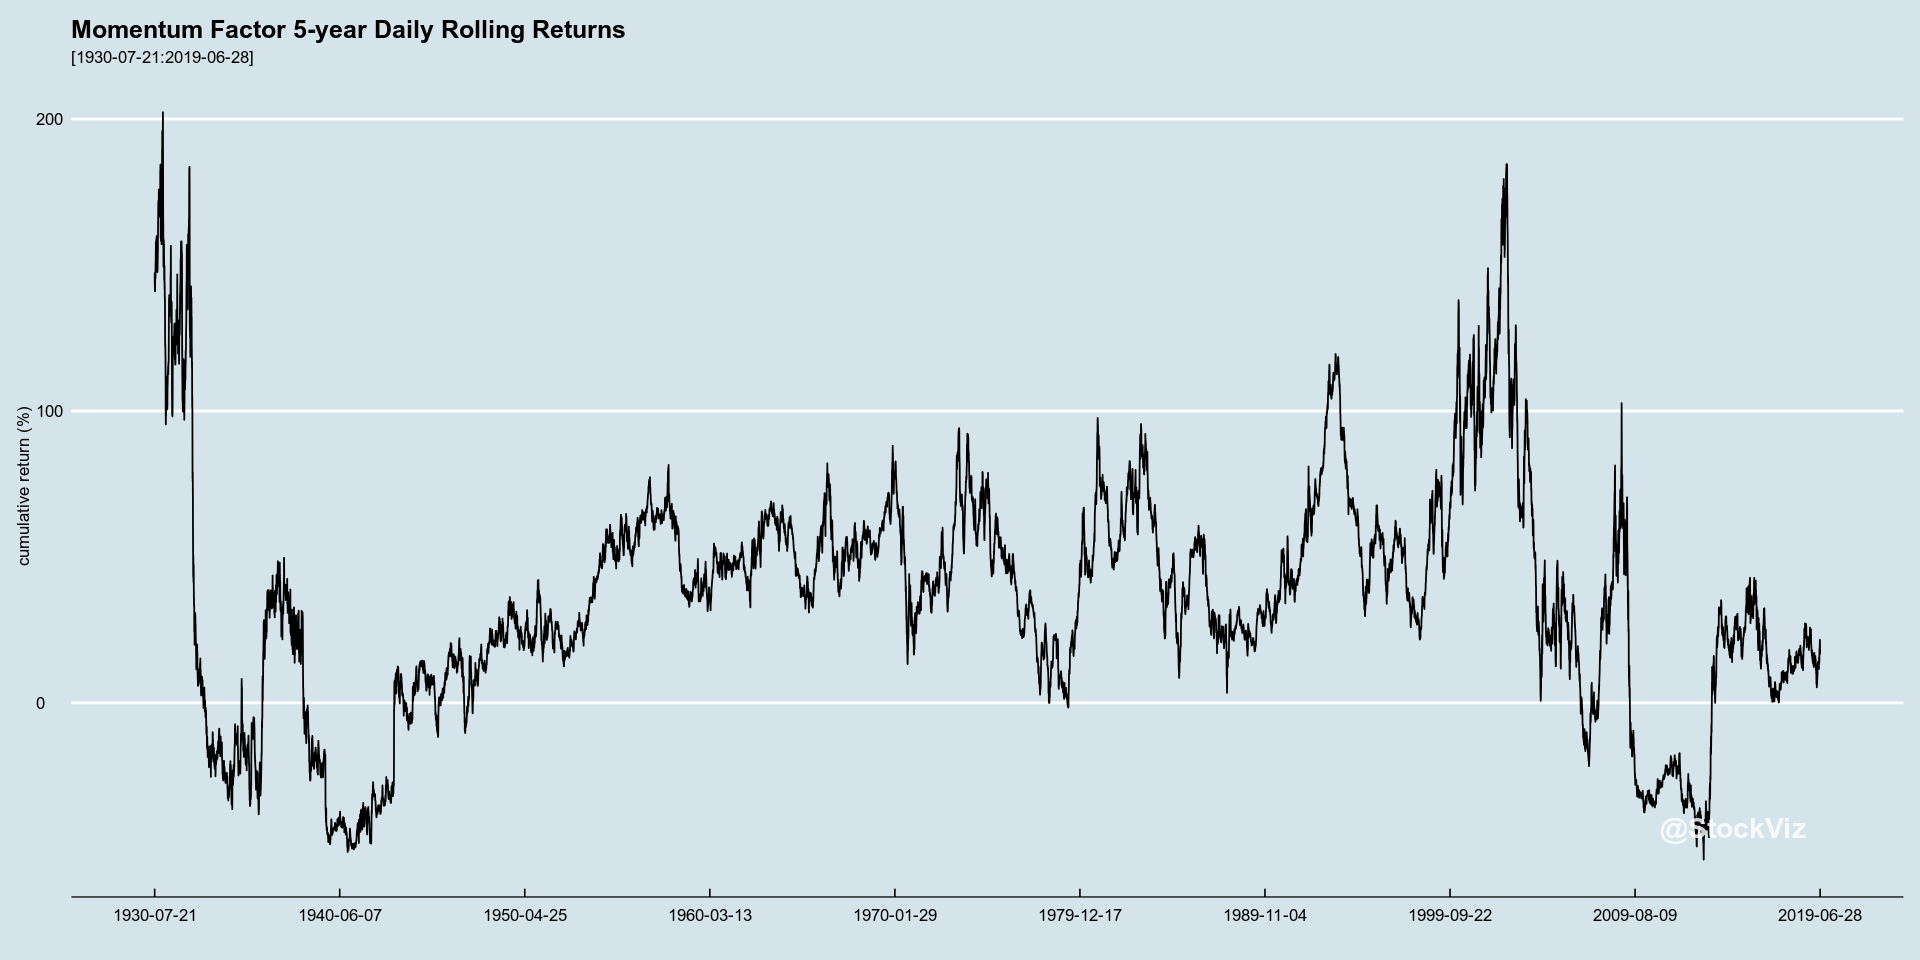

In [4]:
#5-year rolling returns
plotRollingDailyReturns(5)

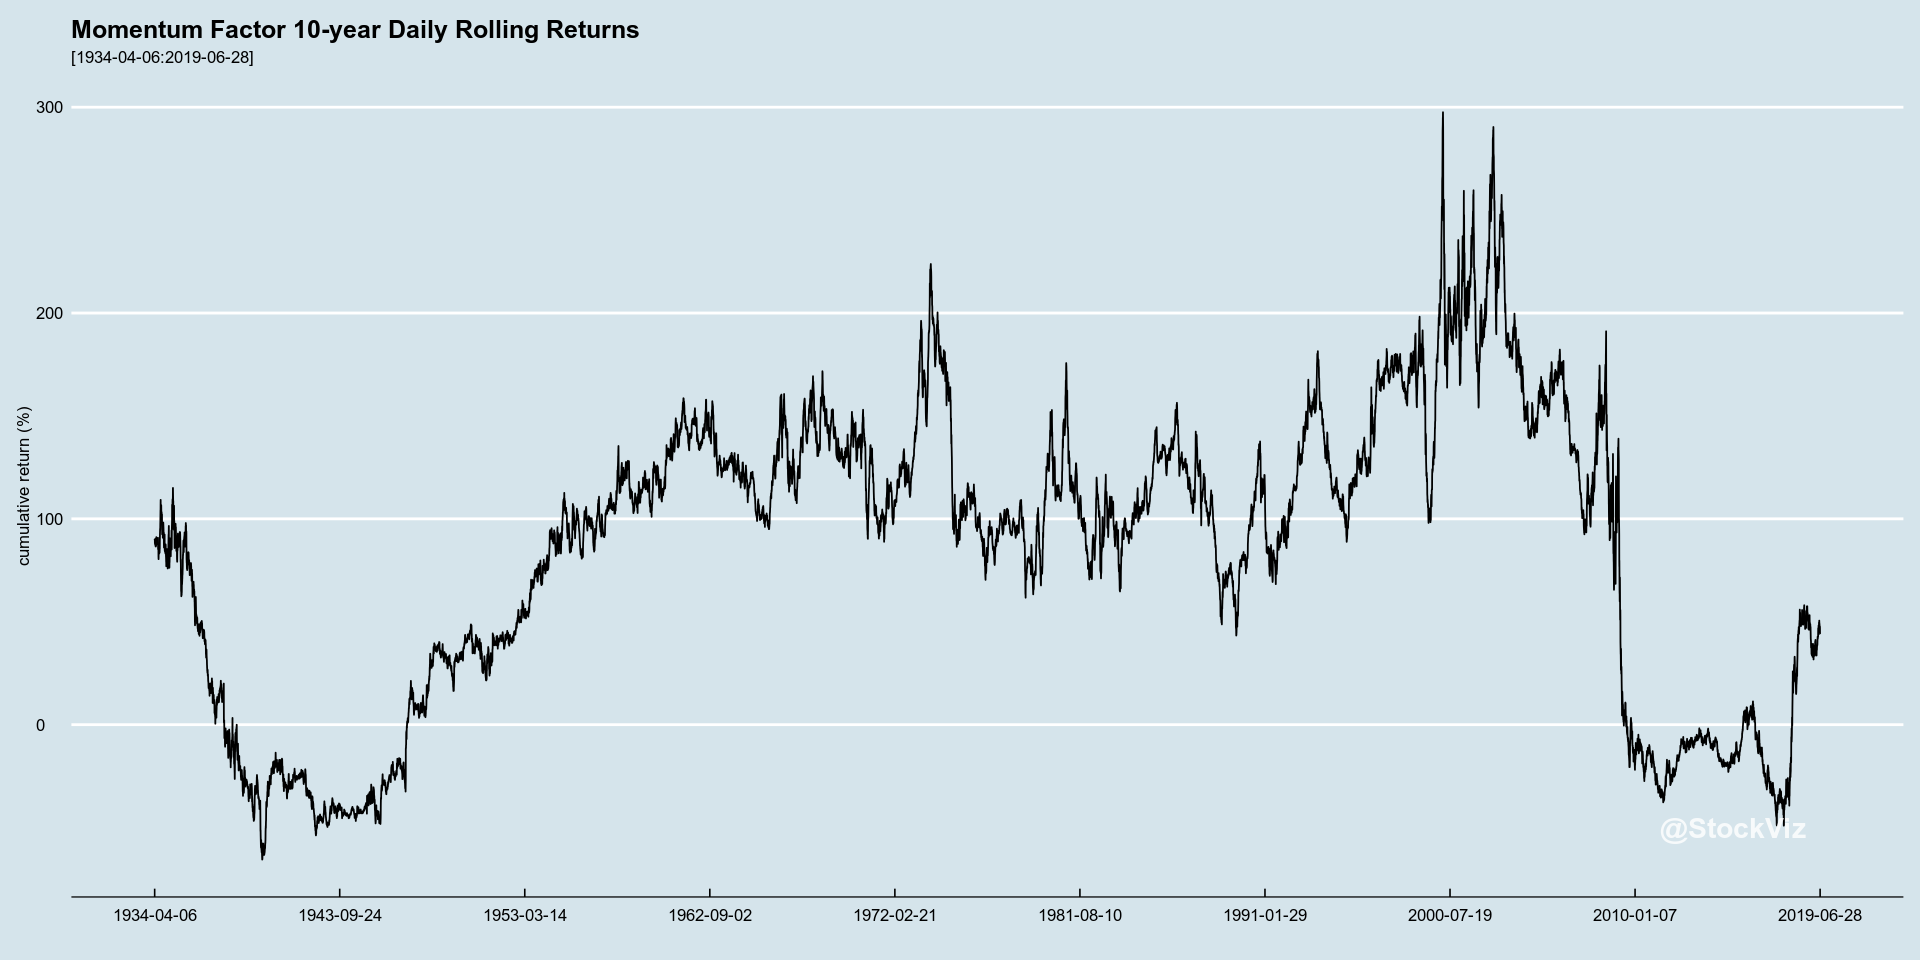

In [5]:
#10-year rolling returns
plotRollingDailyReturns(10)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)